<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

# RNN in TensorFlow Keras - TimeSeries Data <a class="tocSkip">

In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn as sk
from sklearn import preprocessing as skpp
print("sklearn:{}".format(sk.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20,
                     'figure.figsize': [15,10] 
                    }
                   )
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.losses import mean_squared_error as k_mse
from keras.backend import sqrt as k_sqrt
import keras.backend as K

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.13.1
Pandas:0.21.0
sklearn:0.19.1
Matplotlib:2.1.0
TensorFlow:1.4.1


Using TensorFlow backend.


Keras:2.0.9


In [2]:
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

# Read and pre-process the dataset

In [3]:
filepath = os.path.join(datasetslib.datasets_root,
                        'ts-data',
                        'international-airline-passengers-cleaned.csv'
                       ) 
dataframe = pd.read_csv(filepath,
                        usecols=[1],
                        header=0)
dataset = dataframe.values
dataset = dataset.astype(np.float32)

In [4]:
# normalize the dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

In [5]:
# split into train and test sets
train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)
n_x=1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=1)

# Keras SimpleRNN for TimeSeries Data

In [6]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

In [7]:
# create and fit the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 [==============================] - 1s 7ms/step - loss: 0.0161
Epoch 2/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 4/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0051
Epoch 5/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 6/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0036
Epoch 7/20
95/95 [==============================] - 0s 3ms/step - lo

In [8]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 23.27 RMSE
Test Score: 54.13 RMSE


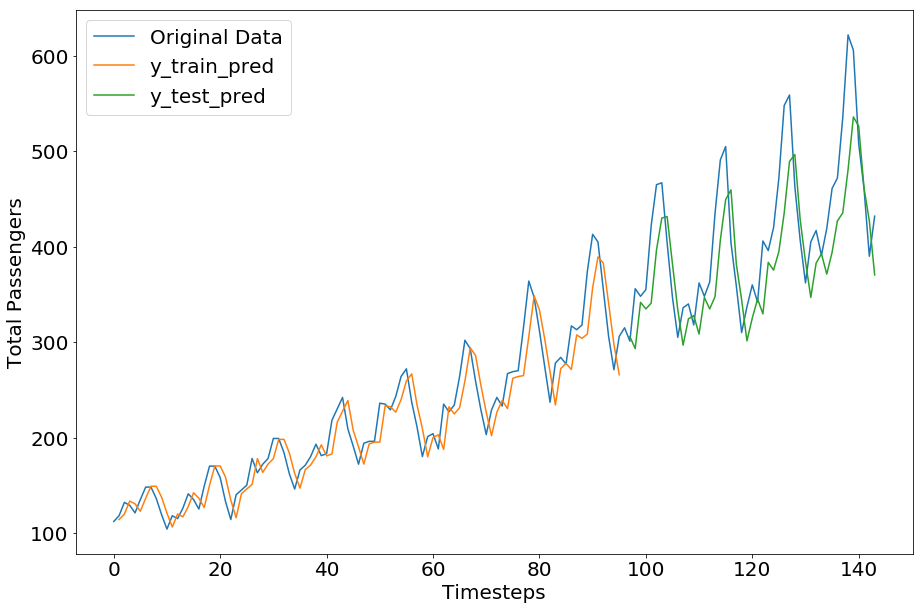

In [9]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset),:]=y_test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras LSTM for TimeSeries Data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 [==============================] - 1s 7ms/step - loss: 0.0551
Epoch 2/20
95/95 [==============================] - 1s 8ms/step - loss: 0.0278
Epoch 3/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 4/20
95/95 [==============================] - 1s 6ms/step - loss: 0.0188
Epoch 5/20
95/95 [==============================] - 1s 5ms/step - loss: 0.0179
Epoch 6/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 7/20
95/95 [==============================] - 1s 5ms/step - 

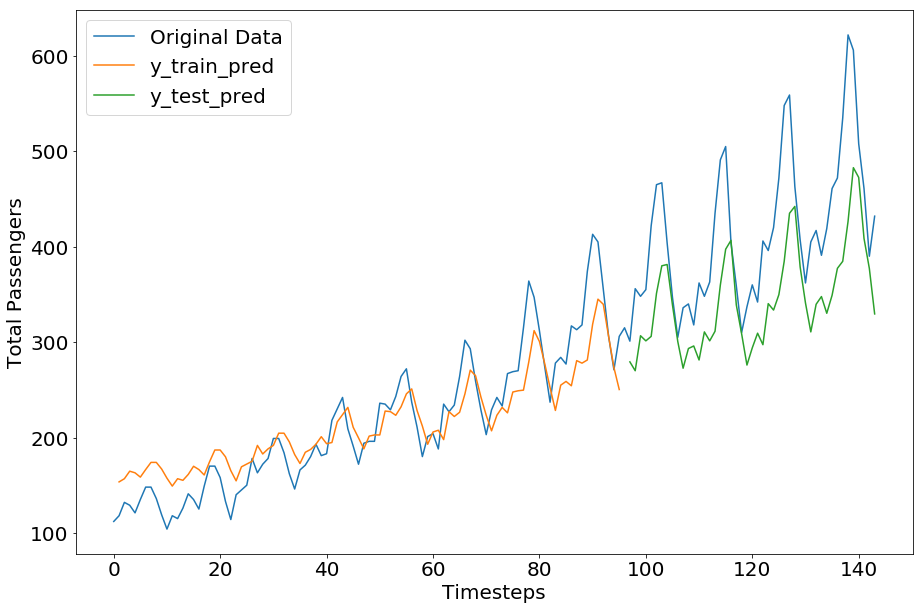

In [10]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

# Keras GRU for TimeSeries Data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
95/95 [==============================] - 1s 7ms/step - loss: 0.0538
Epoch 2/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 3/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 4/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 5/20
95/95 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 6/20
95/95 [==============================] - 0s 5ms/step - loss: 0.0159
Epoch 7/20
95/95 [==============================] - 0s 4ms/step - lo

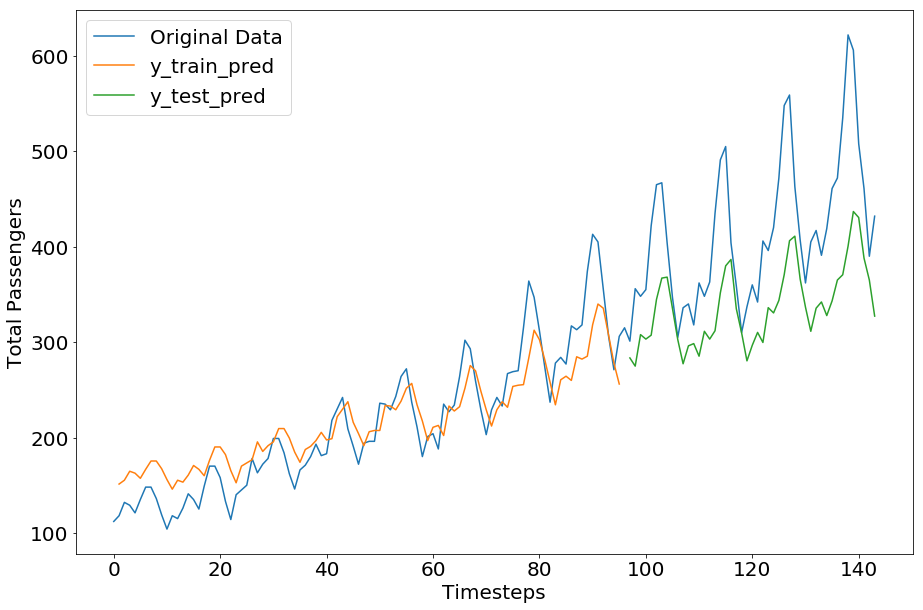

In [11]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], 1)

# create and fit the GRU Model
model = Sequential()
model.add(GRU(units=4, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=20, batch_size=1)

# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()